# Main

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
import os
import cv2
import PIL
from PIL import Image

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [ ]:
#Importing Datasets
img_dir='brain_tumor/'
no_images=os.listdir(img_dir + 'no/')
yes_images=os.listdir(img_dir + 'yes/')
dataset=[]
lab=[]

#No tumour images
for image_name in no_images:
    image=cv2.imread(img_dir + 'no/' +image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((112,112))
    dataset.append(np.array(image))
    lab.append(0)

#Tumour images
for image_name in yes_images:
    image=cv2.imread(img_dir + 'yes/' +image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((112,112))
    dataset.append(np.array(image))
    lab.append(1)

data=np.asarray(dataset)
l=np.asarray(lab)
print(data.shape, l.shape)
print('Total Number of Image: ',len(l))


(253, 112, 112, 3) (253,)
Total Number of Image:  253


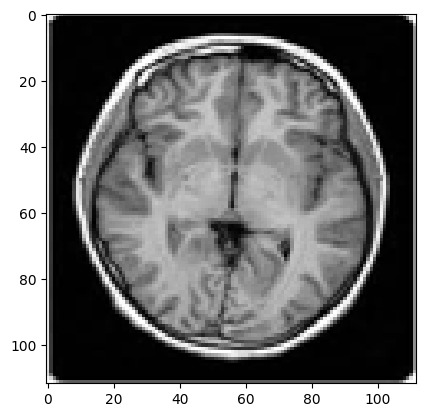

In [ ]:
plt.imshow(data[2])

In [ ]:
data.shape

(253, 112, 112, 3)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data,l, test_size=0.3, shuffle=True, random_state=0)


In [ ]:
x_train.dtype

dtype('uint8')

In [ ]:
#Norm.

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
x_train.shape

(177, 112, 112, 3)

In [ ]:
x_test.shape

(76, 112, 112, 3)

In [ ]:
# Reshape 

img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = x_train.shape[3]
# x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
# x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

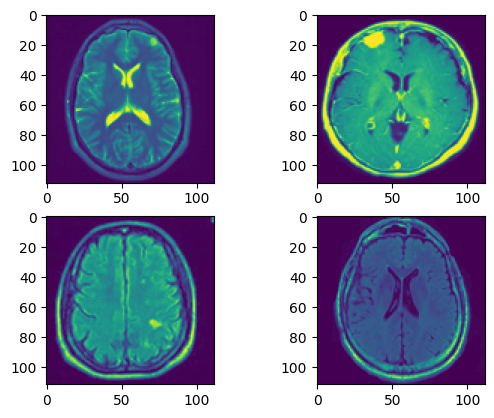

In [ ]:
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[100][:,:,0])

plt.subplot(223)
plt.imshow(x_train[14][:,:,0])

plt.subplot(224)
plt.imshow(x_train[2][:,:,0])
plt.show()

In [ ]:
latent_dim = 21 # Number of latent dim parameters
#low dim = blurry decoded; high dim = sharper decoded
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

In [ ]:
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)


In [ ]:
conv_shape

(None, 56, 56, 64)

In [ ]:
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input


In [ ]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [ ]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [ ]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 56, 56, 64)   18496       ['conv2d[0][0]']                 
                                                                                            

In [ ]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

In [ ]:
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)


In [ ]:
# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 21)]              0         
                                                                 
 dense_1 (Dense)             (None, 200704)            4415488   
                                                                 
 reshape (Reshape)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 112, 112, 32)     18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 112, 112, 3)      867       
 pose)                                                           
                                                                 
Total params: 4,434,819
Trainable params: 4,434,819
Non-tra

In [ ]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [ ]:
y = CustomLayer()([input_img, z_decoded])

In [ ]:

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 56, 56, 64)   18496       ['conv2d[0][0]']                 
                                                                                                

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 75)

In [ ]:
history= vae.fit(x_train, None, epochs = 500, batch_size = 32, validation_split = 0.2, callbacks=[early_stopping])


Train on 141 samples, validate on 36 samples
Epoch 1/500
141/141 [==============================] - ETA: 0s - loss: 0.6910

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


141/141 [==============================] - 24s 173ms/sample - loss: 0.6910 - val_loss: 0.6850
Epoch 2/500
141/141 [==============================] - 18s 128ms/sample - loss: 0.7573 - val_loss: 0.6561
Epoch 3/500
141/141 [==============================] - 17s 124ms/sample - loss: 0.6602 - val_loss: 0.6504
Epoch 4/500
141/141 [==============================] - 17s 122ms/sample - loss: 0.6416 - val_loss: 0.5443
Epoch 5/500
141/141 [==============================] - 17s 122ms/sample - loss: 0.5703 - val_loss: 0.5152
Epoch 6/500
141/141 [==============================] - 17s 122ms/sample - loss: 0.5393 - val_loss: 0.4684
Epoch 7/500
141/141 [==============================] - 18s 126ms/sample - loss: 0.5098 - val_loss: 0.4677
Epoch 8/500
141/141 [==============================] - 19s 135ms/sample - loss: 0.4997 - val_loss: 0.4600
Epoch 9/500
141/141 [==============================] - 17s 123ms/sample - loss: 0.4918 - val_loss: 0.4605
Epoch 10/500
141/141 [==============================] - 18

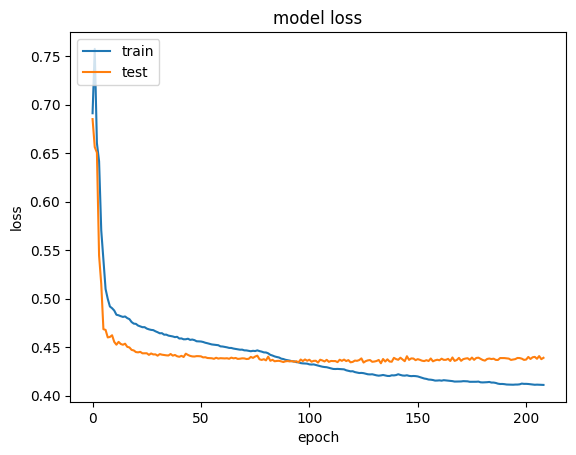

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
n_to_show = 50
reconst_images = decoder.predict(np.random.uniform(-2,4,size=(n_to_show,latent_dim)))

fig = plt.figure(figsize=(112, 112))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
  img = reconst_images[i].squeeze()
  # sub = fig.add_subplot(10, 4, i+1)
  # sub.axis('off')
  # sub.imshow(img)
  plt.imshow(img)
  plt.show()

  plt.savefig('generated_samples/' + 'brain{}.png'.format(i),bbox_inches='tight', pad_inches=0)
 


# Extra

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


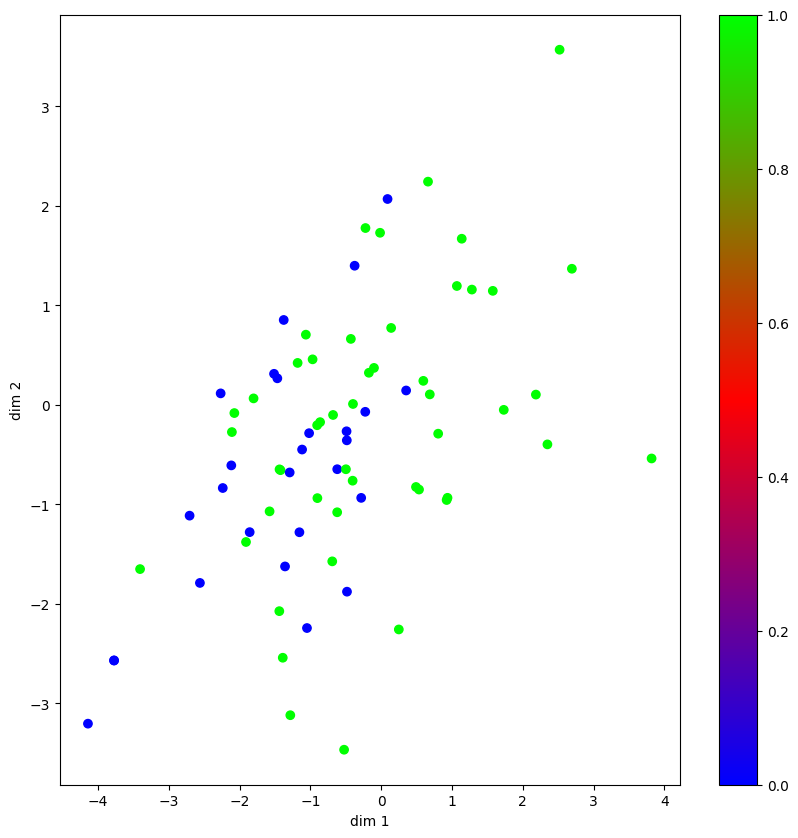

In [ ]:

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 3], mu[:, 4], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

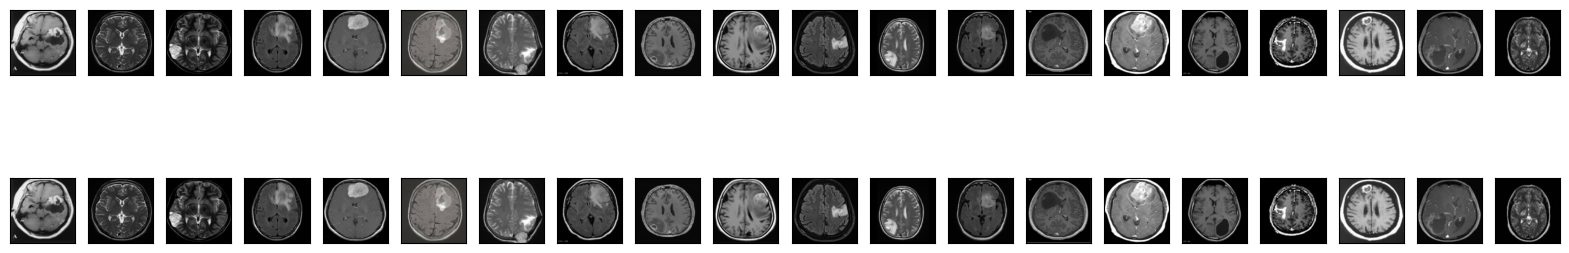

In [ ]:
import matplotlib.pyplot as plt
# Convert the predictions into images
decoded_imgs = vae.predict(x_test)
# Display the original and reconstructed images
n =20 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(112, 112,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(112, 112,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()